### Import Libraries

In [ ]:
pip install imbalanced-learn transformers torch scikit-learn

In [21]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import joblib

### Read the test and train dataset from the checkpoint

In [32]:
train_df = pd.read_csv("../data/final_train_dataset_w59types.csv")

In [33]:
train_df.shape

(7231, 9)

## Data Preprocessing

In [4]:
# Get unique count of values in each column
unique_counts = train_df.apply(lambda x: x.nunique())
print("\nUnique Value Counts:")
print(unique_counts)


Unique Value Counts:
project_id                        7231
project_name                      7165
methodology                        278
region                              14
voluntary_registry                   4
project_type_from_the_registry      99
project_developer                 2512
arb_wa_project                       4
project_type                        59
dtype: int64


### SMOTE to handle Data Imbalance of minority classes

## Identify the outliers from projectTypes

In [5]:

type_df = train_df["project_type"]
type_counts = type_df.value_counts().reset_index()
type_counts.columns = ["project_type", 'count']

type_counts


,project_type,count
0,Cookstoves,1147
1,Wind,811
2,Improved Forest Management,605
3,Hydropower,423
4,Afforestation/Reforestation,380
5,Manure Methane Digester,360
6,Clean Water,330
7,Landfill Methane,306
8,Solar - Centralized,263
9,Rice Emission Reductions,234


In [295]:
# Based on the Zscore, the major classes will be undersampled and minority classes will be oversample

In [6]:
X_train_df = train_df.drop(columns=['project_type'])
Y_train_df = train_df['project_type']

In [7]:
print(X_train_df.shape)

(7231, 8)


In [8]:
## Splitting the train to train and validation sets
X_train_1, X_val_1, Y_train, Y_val  = train_test_split(X_train_df,Y_train_df, test_size=0.1, stratify =Y_train_df,  random_state=42)
print(X_train_1.shape, X_val_1.shape, Y_train.shape, Y_val.shape )

(6507, 8) (724, 8) (6507,) (724,)


In [9]:
X_train = X_train_1.drop(columns=['project_id'])
X_val = X_val_1.drop(columns=['project_id'])


## Encoding the categorical and text features


In [34]:
# Define categorical and text features
categorical_features = ['region', 'voluntary_registry', 'arb_wa_project']
text_features = ['project_name','methodology','project_type_from_the_registry', 'project_developer']


In [14]:
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Preprocessor for categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Preprocessor for text features
text_transformers = [(f'text_{i}', TfidfVectorizer(), col) for i, col in enumerate(text_features)]

# Combine all preprocessors into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
    ] + text_transformers,
    remainder='passthrough'
)

# Define SMOTE and RandomUnderSampler
over_sampling = RandomOverSampler(random_state=42)
sampling_strategy = {
    'Cookstoves': 800
}
under_sampling = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy)

# Pipeline for preprocessing and resampling
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('undersampling', under_sampling),
    ('oversampling', over_sampling)
])

# Apply preprocessing, SMOTE, and undersampling
X_resampled_combined, y_resampled = pipeline.fit_resample(X_train, Y_train)


In [15]:
print(X_resampled_combined.shape, y_resampled.shape)
print(X_resampled_combined.dtype)

(47200, 11628) (47200,)
float64


In [16]:
# Check the class distribution after resampling
resampledCounter = Counter(y_resampled)
originalCounter = Counter(Y_train_df)

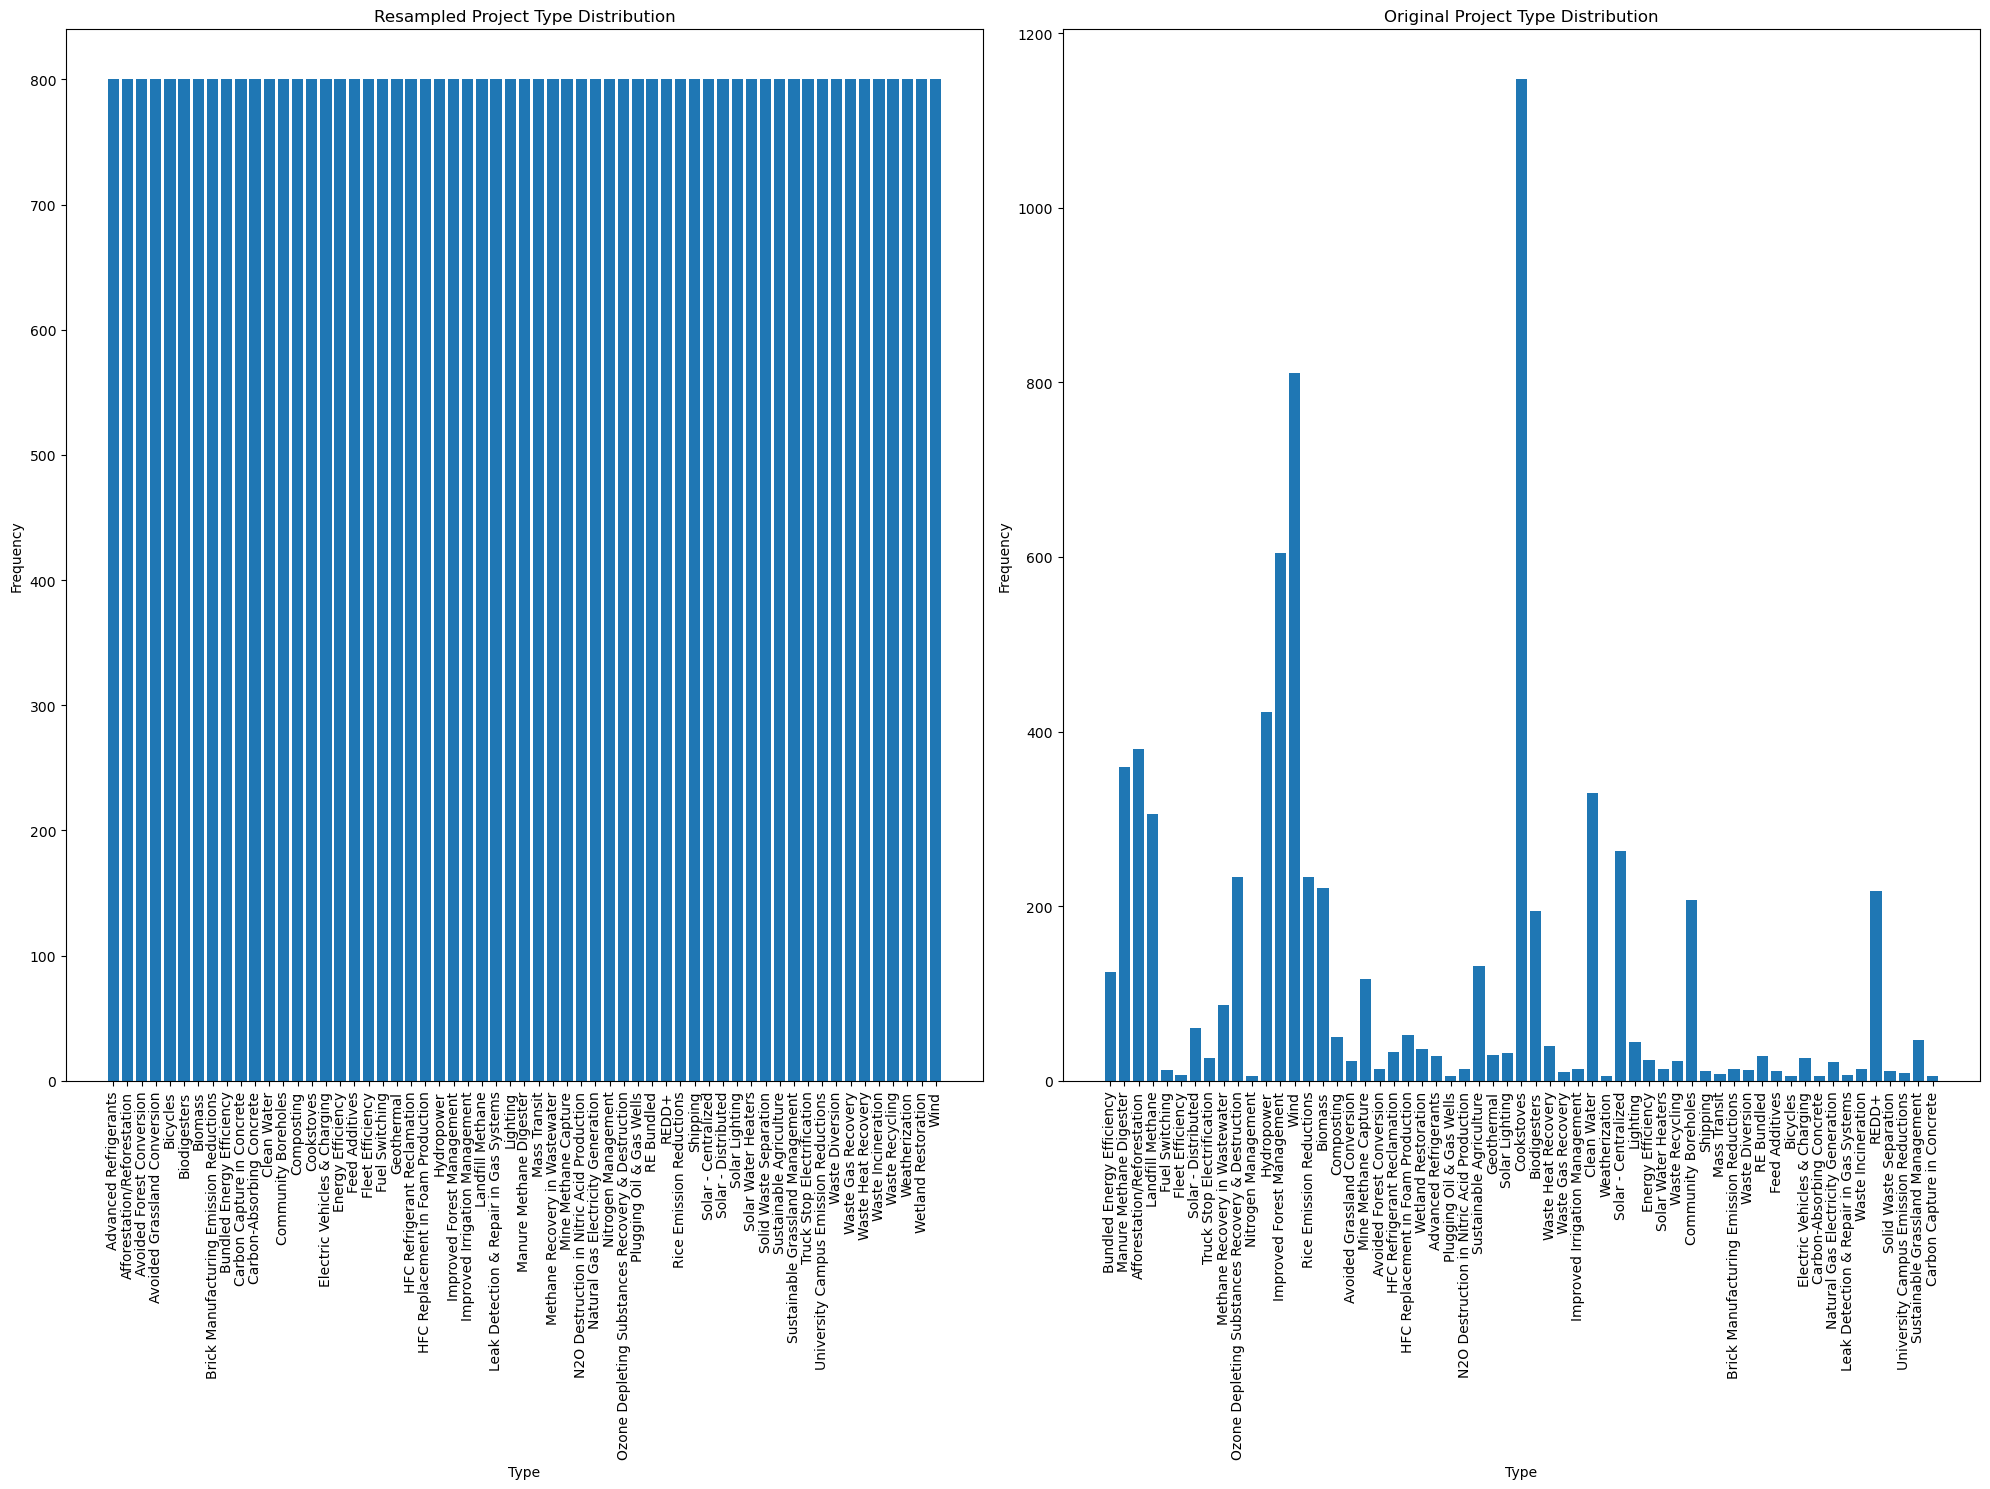

In [17]:
# Plotting histograms
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))

# Resampled class distribution histogram
axes[0].bar(resampledCounter.keys(), resampledCounter.values())
axes[0].set_title('Resampled Project Type Distribution')
axes[0].set_xlabel('Type')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(list(resampledCounter.keys()))
axes[0].set_xticklabels(resampledCounter.keys(), rotation=90)

# Original class distribution histogram
axes[1].bar(originalCounter.keys(), originalCounter.values())
axes[1].set_title('Original Project Type Distribution')
axes[1].set_xlabel('Type')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(list(originalCounter.keys()))
axes[1].set_xticklabels(originalCounter.keys(), rotation=90)

# Display the histograms
plt.tight_layout()
plt.show()


### Logistic Regression

In [18]:
# Define the logistic regression model
logistic_regression = LogisticRegression(max_iter=1000, random_state=42)

# Fit the logistic regression model on the resampled data
logistic_regression.fit(X_resampled_combined, y_resampled)



LogisticRegression(max_iter=1000, random_state=42)

In [19]:
## Save the model and processor with Joblib

joblib.dump(preprocessor, '../data/models/tfidf_onehotencoding_59types.pkl')

# Save the Logistic Regression model
joblib.dump(logistic_regression, '../data/models/logistic_regression_model_59types.pkl')

['../data/models/logistic_regression_model_59types.pkl']

In [20]:
# Make predictions on the val data

X_val_transformed = preprocessor.transform(X_val)
y_pred = logistic_regression.predict(X_val_transformed)

# Get the predicted probabilities for each class
y_pred_proba = logistic_regression.predict_proba(X_val_transformed)
# Evaluate the model and get the classification report
report = classification_report(Y_val, y_pred, output_dict=True)

# Convert the classification report to a DataFrame for a tabular format
report_df = pd.DataFrame(report).transpose()

# Display the classification report table
report_df

/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

,precision,recall,f1-score,support
Advanced Refrigerants,1.000000,1.000000,1.000000,3.000000
Afforestation/Reforestation,0.974359,1.000000,0.987013,38.000000
Avoided Forest Conversion,1.000000,1.000000,1.000000,1.000000
Avoided Grassland Conversion,1.000000,1.000000,1.000000,2.000000
Bicycles,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...
Wetland Restoration,1.000000,1.000000,1.000000,4.000000
Wind,1.000000,0.975309,0.987500,81.000000
accuracy,0.951657,0.951657,0.951657,0.951657
macro avg,0.829673,0.853334,0.835714,724.000000


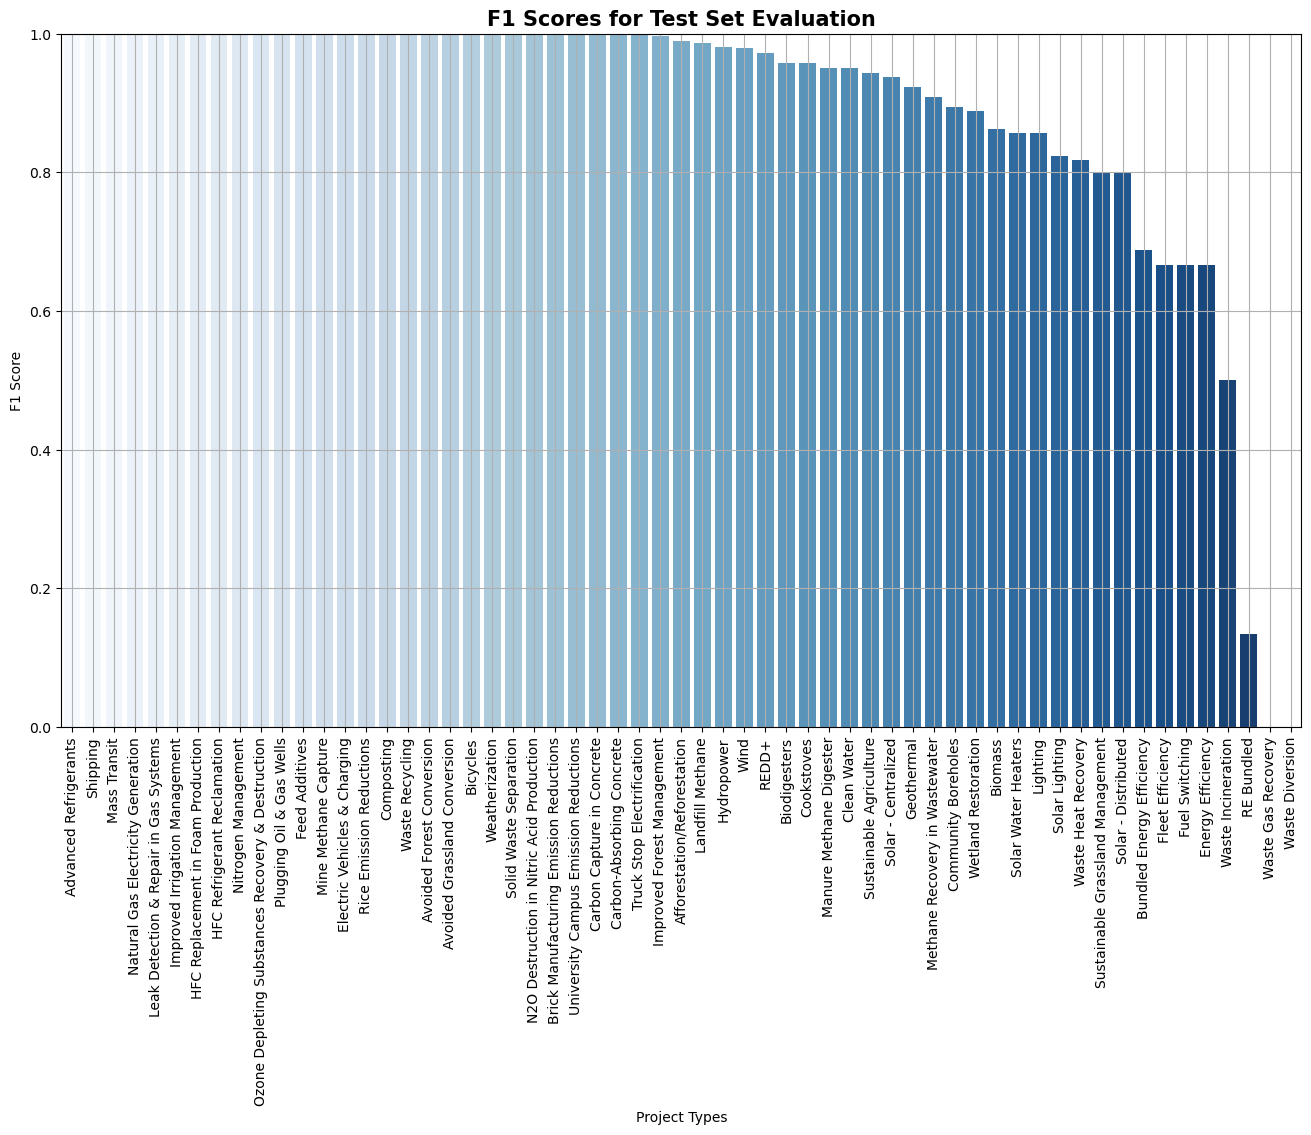

In [28]:
import seaborn as sns
# Extract F1 scores from the classification report
f1_scores = {key: value['f1-score'] for key, value in report.items() if key not in ('accuracy', 'macro avg', 'weighted avg')}

# Convert the F1 scores to a DataFrame for plotting
f1_df = pd.DataFrame(list(f1_scores.items()), columns=['Class', 'F1 Score'])

# Sort the DataFrame by F1 Score in ascending order
f1_df = f1_df.sort_values(by='F1 Score', ascending = False)

# Plot the F1 scores
plt.figure(figsize=(16, 9))
sns.barplot(x='Class', y='F1 Score', data=f1_df, palette='Blues')
plt.title('F1 Scores for Test Set Evaluation', fontsize=15, fontweight='bold')
plt.xlabel('Project Types')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.xticks(rotation=90)  # Rotate x-ticks by 90 degrees
plt.grid(True)
plt.show()

In [26]:
## Check all the incorrect predictions

In [23]:
# Create a DataFrame to compare true labels and predictions
comparison_df = pd.DataFrame({
    'True Label': Y_val,
    'Predicted Label': y_pred,
    'Confidence Level': [max(proba) for proba in y_pred_proba],
    'Correct Prediction': Y_val == y_pred
})

# Extract the dropped feature from the original X_test
dropped_feature_project_id = X_val_1['project_id'].reset_index(drop=True)
#dropped_feature_rbtype = X_val_1['rule-based_type_mapping_first'].reset_index(drop=True)
# Concatenate the input features with the comparison DataFrame
comparison_df = pd.concat([X_val.reset_index(drop=True), comparison_df.reset_index(drop=True)], axis=1)

# Add the dropped feature to the comparison DataFrame
comparison_df['project_id'] = dropped_feature_project_id
#comparison_df['rule-based_type_mapping_first'] = dropped_feature_rbtype
# Display the DataFrame with incorrect predictions
incorrect_predictions = comparison_df[~comparison_df['Correct Prediction']]
print(incorrect_predictions.shape)
incorrect_predictions

(35, 12)


,project_name,methodology,region,voluntary_registry,project_type_from_the_registry,project_developer,arb_wa_project,True Label,Predicted Label,Confidence Level,Correct Prediction,project_id
5,Renewable Energy Project in the State of Ceará,AMS-I.E. Switch from non-renewable biomass for...,Latin America and the Caribbean,ACR,Fuel Switching,Sustainable Carbon - Projetos Ambientais Ltda.,No,Biomass,Fuel Switching,0.426557,False,ACR216
16,3.66 MW poultry litter based power generation ...,AMS-I.D. Grid connected renewable electricity ...,Southern Asia,GS,Biogas - Electricity,South Pole Carbon Asset Management Ltd.,No,Manure Methane Digester,Biomass,0.390461,False,GS400
39,PoA - Energy-Efficient Development for Africa,GS Methodology for Accreditation of Water Bene...,Sub-Saharan Africa,GS,Energy Efficiency - Domestic,Carbonsink (Carbonsink Group S.r.l.),No,Bundled Energy Efficiency,Cookstoves,0.517429,False,GS12102
57,Bundled Solar VCS Project by EKIESL (EKIESL- V...,AMS-I.D. Grid connected renewable electricity ...,Southern Asia,VCS,Energy industries (renewable/non-renewable sou...,Multiple Proponents,No,Solar - Distributed,RE Bundled,0.333181,False,VCS1574
75,Balsas Renewable Energy Project,AMS-I.E. Switch from non-renewable biomass for...,Latin America and the Caribbean,GS,"Biomass, or Liquid Biofuel - Heat",Sustainable Carbon - Projetos Ambientais LTDA,No,Cookstoves,Biomass,0.952327,False,GS1291
77,Distributed Emission Reductions by Bboxx Energ...,AMS-III.AR. Substituting fossil fuel based lig...,Sub-Saharan Africa,GS,Energy Efficiency - Domestic,BBOXX LTD,No,Bundled Energy Efficiency,Solar Lighting,0.400142,False,GS11598
98,Ecofiltro Guatemala Improved Stoves and Water ...,GS TPDDTEC Reduced emissions from cooking and ...,Latin America and the Caribbean,GS,Energy Efficiency - Domestic,Natural Capital Partners,No,Bundled Energy Efficiency,Cookstoves,0.583521,False,GS1321
167,USING DIRECT AIR CAPTURE TO MANUFACTURE CARBON...,VM0043 Methodology for CO2 Utilization in Conc...,Latin America and the Caribbean,VCS,Construction; Manufacturing industries,Partanna Global,No,Carbon-Absorbing Concrete,Carbon Capture in Concrete,0.841975,False,VCS3823
183,GS5047 VPA49 African Improved Cookstoves and C...,GS TPDDTEC Reduced emissions from cooking and ...,Sub-Saharan Africa,GS,Energy Efficiency - Domestic,Likano Project Development GmbH,No,Cookstoves,Bundled Energy Efficiency,0.964979,False,GS10742
184,ACCESS TO CLEAN COOKING AND SUPPORT WOMEN EMPO...,Not provided,Southern Asia,GS,Other,ZENITH ENERGY SERVICES PRIVATE LIMITED,No,Cookstoves,Solar - Distributed,0.275145,False,GS12185


In [29]:
## Confidence level of the result

In [24]:
# Create a DataFrame to compare true labels and predictions with confidence levels
comparison_df = pd.DataFrame({
    'True Label': Y_val,
    'Predicted Label': y_pred,
    'Confidence Level': [max(proba) for proba in y_pred_proba],
    'Correct Prediction': Y_val == y_pred
})
# Extract the dropped feature from the original X_test

dropped_feature_project_id = X_val_1['project_id'].reset_index(drop=True)
#dropped_feature_rbtype = X_val_1['rule-based_type_mapping_first'].reset_index(drop=True)
# Concatenate the input features with the comparison DataFrame
comparison_df = pd.concat([X_val.reset_index(drop=True), comparison_df.reset_index(drop=True)], axis=1)

# Add the dropped feature to the comparison DataFrame
comparison_df['project_id'] = dropped_feature_project_id
#comparison_df['rule-based_type_mapping_first'] = dropped_feature_rbtype

correct_predictions = comparison_df[comparison_df['Correct Prediction']]
correct_predictions

,project_name,methodology,region,voluntary_registry,project_type_from_the_registry,project_developer,arb_wa_project,True Label,Predicted Label,Confidence Level,Correct Prediction,project_id
0,Viet Nam Improved Cookstove Project by KCM – I...,AMS-II.G. Energy efficiency measures in therma...,South-Eastern Asia,VCS,Energy demand,Korea Carbon Management Ltd,No,Cookstoves,Cookstoves,0.963538,True,VCS2487
1,Kumbango POME Methane Capture Project,AMS-I.D. Grid connected renewable electricity ...,Oceania,GS,Biogas - Electricity,Carbon Bridge Pte Ltd,No,Methane Recovery in Wastewater,Methane Recovery in Wastewater,0.925193,True,GS622
2,BONOS X-HAZIL DE LA RUTA SIAN KA´AN,CAR Mexico Forest Protocol,Latin America and the Caribbean,CAR,Forestry - MX,THEEARTHLAB SA de CV,No,Improved Forest Management,Improved Forest Management,0.961228,True,CAR1863
3,Yingkou MSW Incineration and Power Generation ...,ACM0022 Alternative waste treatment processes,Eastern Asia,VCS,Energy industries (renewable/non-renewable sou...,Yingkou Canvest Environmental Power Company Li...,No,Waste Incineration,Waste Incineration,0.967377,True,VCS3225
4,Community Restoration of Native Ecosystems in ...,AR-ACM0003 Afforestation and reforestation of ...,Sub-Saharan Africa,VCS,Agriculture Forestry and Other Land Use,Multiple Proponents,No,Afforestation/Reforestation,Afforestation/Reforestation,0.980741,True,VCS4126
...,...,...,...,...,...,...,...,...,...,...,...,...
719,YBYRÁ REDD+ Project,VM0015 Methodology for Avoided Unplanned Defor...,Latin America and the Caribbean,VCS,Agriculture Forestry and Other Land Use,Multiple Proponents,No,REDD+,REDD+,0.999479,True,VCS4681
720,Panasolar Generation,AMS-I.D. Grid connected renewable electricity ...,Latin America and the Caribbean,GS,Solar Thermal - Electricity,Panasolar Generation,No,Solar - Centralized,Solar - Centralized,0.648326,True,GS3556
721,GS1247 VPA 31 Improved Kitchen Regimes: Chitta...,GS TPDDTEC Reduced emissions from cooking and ...,Southern Asia,GS,Energy Efficiency - Domestic,CO2balance UK ltd,No,Community Boreholes,Community Boreholes,0.878204,True,GS3370
722,ECC-PA-ODS-003,ARB Compliance Offset Protocol: Destruction of...,North America,CAR,Ozone Depleting Substances - U.S.,Environmental Credit Corp.,ARB Early Action,Ozone Depleting Substances Recovery & Destruction,Ozone Depleting Substances Recovery & Destruction,0.996635,True,CAR947


## Final Test Evaluation 

In [35]:
# get the test dataset
test_df = pd.read_csv("../data/final_test_dataset_w59types.csv")

In [36]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1809 entries, 0 to 1808
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   project_id                      1809 non-null   object
 1   project_name                    1809 non-null   object
 2   methodology                     1809 non-null   object
 3   region                          1809 non-null   object
 4   voluntary_registry              1809 non-null   object
 5   project_type_from_the_registry  1809 non-null   object
 6   project_developer               1809 non-null   object
 7   arb_wa_project                  1809 non-null   object
 8   project_type                    1809 non-null   object
dtypes: object(9)
memory usage: 127.3+ KB


In [37]:
# Creating the Features and Label datasets for test dataset
X_test_df = test_df.drop(columns=['project_type'])
Y_test = test_df['project_type']

In [38]:
X_test = X_test_df.drop(columns=['project_id'])

In [39]:
# Load the model and preprocessor from the Joblib
model = joblib.load('../data/models/logistic_regression_model_59types.pkl')
preprocessor = joblib.load('../data/models/tfidf_onehotencoding_59types.pkl')

In [40]:
X_test_transformed = preprocessor.transform(X_test)
y_pred = model.predict(X_test_transformed)
        
# Get the predicted probabilities for each class
y_pred_proba = model.predict_proba(X_test_transformed)
# Create a DataFrame for predictions and confidence
predictions = pd.DataFrame(y_pred_proba, columns=model.classes_)
        
# Evaluate the model and get the classification report
report_test = classification_report(Y_test, y_pred, output_dict=True)

# Convert the classification report to a DataFrame for a tabular format
report_df_test = pd.DataFrame(report).transpose()

# Display the classification report table
report_df_test

/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

,precision,recall,f1-score,support
Advanced Refrigerants,1.000000,1.000000,1.000000,7.000000
Afforestation/Reforestation,0.979381,1.000000,0.989583,95.000000
Avoided Forest Conversion,1.000000,1.000000,1.000000,3.000000
Avoided Grassland Conversion,1.000000,1.000000,1.000000,6.000000
Bicycles,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...
Wetland Restoration,0.888889,0.888889,0.888889,9.000000
Wind,0.985075,0.975369,0.980198,203.000000
accuracy,0.949143,0.949143,0.949143,0.949143
macro avg,0.884017,0.896530,0.887431,1809.000000


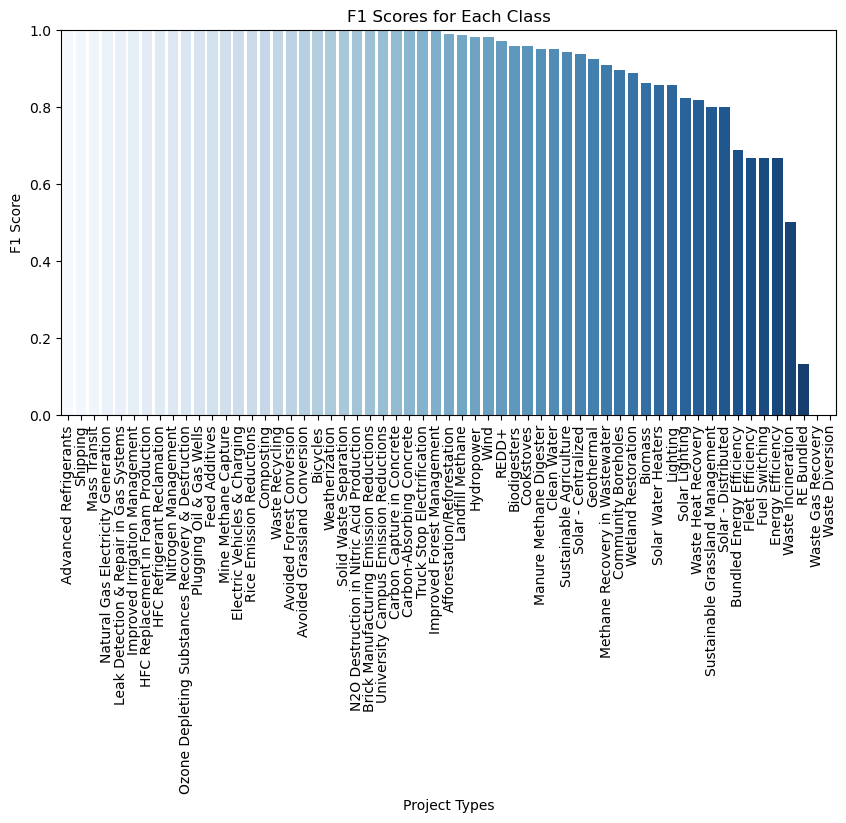

In [41]:
import seaborn as sns
# Extract F1 scores from the classification report
f1_scores = {key: value['f1-score'] for key, value in report_test.items() if key not in ('accuracy', 'macro avg', 'weighted avg')}

# Convert the F1 scores to a DataFrame for plotting
f1_df = pd.DataFrame(list(f1_scores.items()), columns=['Class', 'F1 Score'])

# Sort the DataFrame by F1 Score in ascending order
f1_df = f1_df.sort_values(by='F1 Score', ascending = False)

# Plot the F1 scores
plt.figure(figsize=(10, 5))
sns.barplot(x='Class', y='F1 Score', data=f1_df, palette='Blues')
plt.title('F1 Scores for Each Class')
plt.xlabel('Project Types')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.xticks(rotation=90)  # Rotate x-ticks by 90 degrees
#plt.grid(True)
# Save the figure
plt.savefig("f1_scores_plot.png", bbox_inches='tight')
plt.show()

In [43]:
# Create a DataFrame to compare true labels and predictions
comparison_df = pd.DataFrame({
    'True Label': Y_test,
    'Predicted Label': y_pred,
    'Confidence Level': [max(proba) for proba in y_pred_proba],
    'Correct Prediction': Y_test == y_pred
})

# Extract the dropped feature from the original X_test
dropped_feature_project_id = X_test_df['project_id'].reset_index(drop=True)
#dropped_feature_rbtype = X_val_1['rule-based_type_mapping_first'].reset_index(drop=True)
# Concatenate the input features with the comparison DataFrame
comparison_df = pd.concat([X_test_df.reset_index(drop=True), comparison_df.reset_index(drop=True)], axis=1)

# Add the dropped feature to the comparison DataFrame
comparison_df['project_id'] = dropped_feature_project_id
#comparison_df['rule-based_type_mapping_first'] = dropped_feature_rbtype
# Display the DataFrame with incorrect predictions
incorrect_predictions = comparison_df[~comparison_df['Correct Prediction']]
print(incorrect_predictions.shape)
incorrect_predictions

(92, 12)


,project_id,project_name,methodology,region,voluntary_registry,project_type_from_the_registry,project_developer,arb_wa_project,True Label,Predicted Label,Confidence Level,Correct Prediction
9,ACR162,International Paper,"Monitoring, Reporting and Verification Protoco...",North America,ACR,Energy Efficiency,Blue Source,No,Energy Efficiency,Fleet Efficiency,0.143536,False
163,CAR578,Cottonwood Dairy Organic Waste Digestion Project,CAR U.S. Organic Waste Digestion Protocol,North America,CAR,Organic Waste Digestion,Grey K Trading Limited,No,Manure Methane Digester,Methane Recovery in Wastewater,0.450313,False
318,GS337,Kuyasa low-cost urban housing energy upgrade p...,,Sub-Saharan Africa,GS,Energy Efficiency - Domestic,atmosfair gGmbH,No,Bundled Energy Efficiency,Cookstoves,0.611888,False
330,GS666,Installation of Biogas Plant by INSEDA Members...,,Southern Asia,GS,Biogas - Electricity,First Climate Markets AG,No,Biodigesters,Manure Methane Digester,0.304826,False
398,GS1142,Historical Roll Out GS Large Scale VER Project,Other,Sub-Saharan Africa,GS,Energy Efficiency - Domestic,Eskom Holdings SOC Limited,No,Lighting,Cookstoves,0.550283,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1770,VCS4589,Biogas-based Manure Management Program,AMS-I.C. Thermal energy production with or wit...,Southern Asia,VCS,Energy industries (renewable/non-renewable sou...,Dugdh Utpadak Sahkari Sangh Limited (DUSSL),No,Manure Methane Digester,Biomass,0.507810,False
1774,VCS4629,Lishu Blackland Conservation Project in Jilin ...,VM0042 Methodology for Improved Agricultural L...,Eastern Asia,VCS,Agriculture Forestry and Other Land Use,"Jilin Kangfu Environmental Energy Co., Ltd.",No,Sustainable Grassland Management,Sustainable Agriculture,0.981053,False
1779,VCS4649,CBG Plant at Sainsons,AMS-III.H. Methane recovery in wastewater trea...,Southern Asia,VCS,Transport; Waste handling and disposal,Multiple Proponents,No,Methane Recovery in Wastewater,Manure Methane Digester,0.318010,False
1780,VCS4650,CBG GENERATION FROM MSW,ACM0022 Alternative waste treatment processes,Southern Asia,VCS,Energy industries (renewable/non-renewable sou...,Indo Enviro Integrated Solutions Private Limited,No,Waste Incineration,Biomass,0.406778,False
